<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [12]</a>'.</span>

In [1]:
# | code-summary: code -- load dependencies and data and select parameters

from compmemlearn.fitting import generate_objective_function
from compmemlearn.datasets import events_metadata, simulate_df, generate_trial_mask
from scipy.optimize import differential_evolution
from numba.typed import List, Dict
from numba.core import types
from numba import njit
from psifr import fr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
import os

lb = np.finfo(float).eps
ub = 1 - np.finfo(float).eps

figure_caption = """Distribution of log-likelihood scores of recall sequences exhibited by each subject in dataset under each considered model."""

section_tag = "LohnasCondition1"

data_path = "../data/LohnasKahana2014.csv"
results_path = "results/"
trial_query = "condition == 1"

model_paths = ["compmemlearn.models.Classic_CMR", "compmemlearn.models.Instance_CMR", "compmemlearn.models.Dual_Instance_CMR"]

model_names = ["PrototypeCMR", "InstanceCMR", "Dual Memory ICMR"]

free_parameters = [
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        #    'choice_sensitivity',
        "context_sensitivity",
        #    'feature_sensitivity'
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        #    'choice_sensitivity',
        "context_sensitivity",
        #    'feature_sensitivity'
        "delay_drift_rate",
    ],
]

bounds = [
    [
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, 100],
        [lb, 100],
        [lb, ub],
        [lb, 10],
        [lb, 10],
        [lb, ub],
    ],
    [
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, 100],
        [lb, 100],
        [lb, ub],
        [lb, 10],
        [lb, 10],
        [lb, ub],
    ],
    [
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, 100],
        [lb, 100],
        [lb, ub],
        [lb, 10],
        [lb, 10],
        [lb, ub],
    ],
]

fixed_parameters = [
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
         'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    {"choice_sensitivity": 1, "feature_sensitivity": 1, 'mfc_familiarity_scale': 0, 
         'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0},
    {"choice_sensitivity": 1, "feature_sensitivity": 1, 'mfc_familiarity_scale': 0, 
         'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0},
]

analysis_paths = ['compmemlearn.analyses.plot_spc', 'compmemlearn.analyses.plot_crp', 'compmemlearn.analyses.plot_pfr']
analysis_names = ['spc', 'crp', 'pfr']

experiment_count = 100


In [2]:
# Parameters
data_path = "data/HowardKahana2005.csv"
trial_query = "condition == 1"
model_paths = [
    "compmemlearn.models.Base_CMR",
    "compmemlearn.models.Single_ICMR",
    "compmemlearn.models.Single_ICMR",
    "compmemlearn.models.Single_ICMR",
    "compmemlearn.models.Single_ICMR",
]
model_names = ["PrototypeCMR", "ICMR_1_0_0", "ICMR_1_0_1", "ICMR_1_1_0", "ICMR_1_1_1"]
free_parameters = [
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "context_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "context_sensitivity",
        "delay_drift_rate",
    ],
]
bounds = [
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
]
fixed_parameters = [
    {},
    {"feature_sensitivity": 1, "context_sensitivity": 1, "learn_first": False},
    {"feature_sensitivity": 1, "context_sensitivity": 1, "learn_first": True},
    {"feature_sensitivity": 1, "choice_sensitivity": 1, "learn_first": False},
    {"feature_sensitivity": 1, "choice_sensitivity": 1, "learn_first": True},
]
section_tag = "HowardKahana2005Cond1"


In [3]:
#| code-summary: code -- test that specified parameters are valid
#| output: false

events = pd.read_csv(data_path)

trials, list_lengths, presentations = events_metadata(events)
trial_mask = generate_trial_mask(events, trial_query)

# import models from specified source
models = []
for i in range(len(model_paths)):
    module_name, model_name = model_paths[i].rsplit('.',1) #TODO: add handling for case with no `.`
    module = importlib.import_module(module_name)
    models.append(getattr(module, model_name))

# import analyses from specified source
analyses = []
for i in range(len(analysis_paths)):
    module_name, analysis_name = analysis_paths[i].rsplit('.',1) #TODO: add handling for case with no `.`
    module = importlib.import_module(module_name)
    analyses.append(getattr(module, analysis_name))

# make sure model initializes with provided parameters and boundaries
for model_index, model_class in enumerate(models):

    @njit(fastmath=True, nogil=True)
    def init_model(item_count, presentation_count, parameters):
        return model_class(item_count, presentation_count, parameters)

    subject_specific_trial_mask = np.logical_and(
                generate_trial_mask(events, f'subject == {pd.unique(events.subject)[0]}'), trial_mask)

    cost_function = generate_objective_function(
        [trials[i][subject_specific_trial_mask[i]] for i in range(len(trials))],
        [presentations[i][subject_specific_trial_mask[i]] for i in range(len(presentations))],
        list_lengths,
        init_model,
        fixed_parameters[model_index],
        free_parameters[model_index],
    )
    print(cost_function)
    
    for boundary_index in range(2):
        x = np.array([each[boundary_index] for each in bounds[model_index]])
        assert(len(x) == len(free_parameters[model_index])) 

        # parameter configuration
        parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
        for name, value in fixed_parameters[model_index].items():
            parameters[name] = value
        for i in range(len(free_parameters[model_index])):
                parameters[free_parameters[model_index][i]] = x[i]

        model = init_model(20, 20, parameters)
        model.experience(model.items)
        model.free_recall()

        print(cost_function(x))
print('dependencies and parameters validated')
#print(trial_index, recall_index, recall, trial, likelihood[trial_index, recall_index], model.outcome_probabilities())

<function lohnas_objective_function.<locals>.objective_function at 0x2aef8c369670>


254.09849171213256
469.72744497173227


<function lohnas_objective_function.<locals>.objective_function at 0x2aef8dd26700>


254.09849171213256
469.72744497173227
<function lohnas_objective_function.<locals>.objective_function at 0x2aef8d056f70>


254.09849171213256
469.72744497173227
<function lohnas_objective_function.<locals>.objective_function at 0x2aef8e4f04c0>


254.09849171213256
469.72744497173227
<function lohnas_objective_function.<locals>.objective_function at 0x2aef8e06c820>


254.09849171213256
469.72744497173227
dependencies and parameters validated


In [4]:
# | code-summary: code -- 1) fit each model class participant-by-participant
# | output: false

for model_index, model_class in enumerate(models):

    # load individual fits for this model and section tag from csv if they exist
    if os.path.isfile(results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index])):
        pd.read_csv(results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index]))
        print('individual fits for {} with tag {} already exist'.format(model_names[model_index], section_tag))

    # otherwise, fit each participant individually
    else:
        model_individual_fits = []

        @njit(fastmath=True, nogil=True)
        def init_model(item_count, presentation_count, parameters):
            return model_class(item_count, presentation_count, parameters)

        for subject in pd.unique(events.subject):
            print(f'{model_names[model_index]}, Subject {subject}')

            subject_specific_trial_mask = np.logical_and(
                generate_trial_mask(events, f'subject == {subject}'), trial_mask)
            
            try:
                # cost function to be minimized
                # ours scales inversely with the probability that the data could have been
                # generated using the specified parameters and our model
                cost_function = generate_objective_function(
                    [trials[i][subject_specific_trial_mask[i]] for i in range(len(trials))],
                    [presentations[i][subject_specific_trial_mask[i]] for i in range(len(presentations))],
                    list_lengths,
                    init_model,
                    fixed_parameters[model_index],
                    free_parameters[model_index],
                )
            except ValueError:
                continue

            fit_result =  differential_evolution(cost_function, bounds[model_index], disp=False)

            fitted_parameters = {
                'subject': subject, 'trial_count': np.sum(subject_specific_trial_mask), 
                'likelihood': fit_result.fun, 'model': model_names[model_index]
                }
            for i in range(len(fit_result.x)):
                fitted_parameters[free_parameters[model_index][i]] = fit_result.x[i]
            for key in fixed_parameters[model_index]:
                fitted_parameters[key] = fixed_parameters[model_index][key]

            model_individual_fits.append(pd.DataFrame.from_dict(fitted_parameters, orient='index').T)
            print(model_individual_fits[-1]['likelihood'][0])

        model_individual_fits = pd.concat(model_individual_fits, ignore_index=True)
        model_individual_fits.to_csv(
            results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index]), index=False)

individual fits for PrototypeCMR with tag HowardKahana2005Cond1 already exist
ICMR_1_0_0, Subject 118


110.5654077697244
ICMR_1_0_0, Subject 119


149.53187601395996
ICMR_1_0_0, Subject 123


146.15065786756077
ICMR_1_0_0, Subject 124


194.9738733531272
ICMR_1_0_0, Subject 125


261.9956752843151
ICMR_1_0_0, Subject 126


236.40722816010737
ICMR_1_0_0, Subject 128


102.42793987902873
ICMR_1_0_0, Subject 129


81.88302330831465
ICMR_1_0_0, Subject 130


193.97504248871047
ICMR_1_0_0, Subject 131


95.17116102190012
ICMR_1_0_0, Subject 132


147.18398112204292
ICMR_1_0_0, Subject 133


204.50247482506154
ICMR_1_0_0, Subject 134


121.23365481831674
ICMR_1_0_0, Subject 135


67.91776848612851
ICMR_1_0_0, Subject 136


277.4374943951535
ICMR_1_0_0, Subject 137


190.47223980988542
ICMR_1_0_0, Subject 138


100.9432333344032
ICMR_1_0_0, Subject 139


137.69994017255078
ICMR_1_0_0, Subject 140


167.48810217753982
ICMR_1_0_0, Subject 141


59.778256922813654
ICMR_1_0_0, Subject 142


120.72997732770777
ICMR_1_0_0, Subject 144


116.25778279902367
ICMR_1_0_0, Subject 145


112.88301280635481
ICMR_1_0_0, Subject 146


114.35276224774276
ICMR_1_0_0, Subject 147


164.860080240871
ICMR_1_0_0, Subject 148


87.46806475486295
ICMR_1_0_0, Subject 149


202.31575617447
ICMR_1_0_0, Subject 150


161.73619000766325
ICMR_1_0_0, Subject 151


103.01966011377269
ICMR_1_0_0, Subject 152


96.07635566010518
ICMR_1_0_0, Subject 153


139.02299883788766
ICMR_1_0_0, Subject 154


161.9135192030977
ICMR_1_0_0, Subject 155


94.4667503903584
ICMR_1_0_0, Subject 156


220.55996553239814
ICMR_1_0_0, Subject 157


172.73798962283092
ICMR_1_0_0, Subject 158


173.467439822955
ICMR_1_0_0, Subject 159


247.5562061536402
ICMR_1_0_0, Subject 160


138.53599144082247
ICMR_1_0_0, Subject 161


86.82767809087703
ICMR_1_0_0, Subject 162


102.21430877241801
ICMR_1_0_0, Subject 163


155.91109173000208
ICMR_1_0_0, Subject 164


144.65313866428409
ICMR_1_0_0, Subject 165


228.6304170400957
ICMR_1_0_0, Subject 166


129.53046435374856
ICMR_1_0_0, Subject 167


298.6878061666801
ICMR_1_0_0, Subject 168


101.66780518906495
ICMR_1_0_0, Subject 169


178.7613452429499
ICMR_1_0_0, Subject 170


91.87523768439272
ICMR_1_0_0, Subject 171


114.78048900131088
ICMR_1_0_0, Subject 172


133.4749520826157
ICMR_1_0_0, Subject 173


86.1502348662794
ICMR_1_0_0, Subject 174


177.68147222665226
ICMR_1_0_0, Subject 175


188.80422363758228
ICMR_1_0_0, Subject 176


158.5626824556436
ICMR_1_0_0, Subject 177


140.21236925110114
ICMR_1_0_0, Subject 178


162.44075892588307
ICMR_1_0_0, Subject 179


176.47936866937042
ICMR_1_0_0, Subject 180


147.78089557242066
ICMR_1_0_0, Subject 300


141.4691949320843
ICMR_1_0_0, Subject 301


112.62676699790647
ICMR_1_0_0, Subject 302


142.1425484248993
ICMR_1_0_0, Subject 311


178.89024394104544
ICMR_1_0_0, Subject 312


162.8583945599272
ICMR_1_0_0, Subject 313


265.96588218698446
ICMR_1_0_0, Subject 314


190.11426413109527
ICMR_1_0_0, Subject 315


221.20768247823855
ICMR_1_0_1, Subject 118


112.50056434916208
ICMR_1_0_1, Subject 119


151.930392068767
ICMR_1_0_1, Subject 123


143.43083671000906
ICMR_1_0_1, Subject 124


198.80865267438443
ICMR_1_0_1, Subject 125


261.19691281755865
ICMR_1_0_1, Subject 126


228.77339110778826
ICMR_1_0_1, Subject 128


102.71638590212584
ICMR_1_0_1, Subject 129


83.93083928247314
ICMR_1_0_1, Subject 130


194.40230081434422
ICMR_1_0_1, Subject 131


95.37675327117547
ICMR_1_0_1, Subject 132


147.41417247320302
ICMR_1_0_1, Subject 133


206.87499133589964
ICMR_1_0_1, Subject 134


122.10737954836019
ICMR_1_0_1, Subject 135


67.89304389609478
ICMR_1_0_1, Subject 136


296.33328446985524
ICMR_1_0_1, Subject 137


191.06026397612146
ICMR_1_0_1, Subject 138


102.68466026510843
ICMR_1_0_1, Subject 139


136.63431000401488
ICMR_1_0_1, Subject 140


167.74905826536937
ICMR_1_0_1, Subject 141


60.52582388560843
ICMR_1_0_1, Subject 142


120.7771692854076
ICMR_1_0_1, Subject 144


116.39467278875586
ICMR_1_0_1, Subject 145


112.22552895636788
ICMR_1_0_1, Subject 146


115.57210365073345
ICMR_1_0_1, Subject 147


163.84915175679208
ICMR_1_0_1, Subject 148


90.7965316149983
ICMR_1_0_1, Subject 149


204.2828466222625
ICMR_1_0_1, Subject 150


162.1870479932107
ICMR_1_0_1, Subject 151


104.17507922920299
ICMR_1_0_1, Subject 152


91.94112681743205
ICMR_1_0_1, Subject 153


139.2660725116289
ICMR_1_0_1, Subject 154


171.10751180934852
ICMR_1_0_1, Subject 155


93.46991592306998
ICMR_1_0_1, Subject 156


220.54985798388367
ICMR_1_0_1, Subject 157


174.2247050763531
ICMR_1_0_1, Subject 158


167.10708498614375
ICMR_1_0_1, Subject 159


247.5562110435545
ICMR_1_0_1, Subject 160


135.47570956553832
ICMR_1_0_1, Subject 161


87.05446351114037
ICMR_1_0_1, Subject 162


108.61117964107159
ICMR_1_0_1, Subject 163


155.9112515688348
ICMR_1_0_1, Subject 164


141.38626680979615
ICMR_1_0_1, Subject 165


228.52971720336708
ICMR_1_0_1, Subject 166


134.3750329435049
ICMR_1_0_1, Subject 167


290.97795949172803
ICMR_1_0_1, Subject 168


100.88775156393048
ICMR_1_0_1, Subject 169


183.02963030468825
ICMR_1_0_1, Subject 170


94.55571946417587
ICMR_1_0_1, Subject 171


113.314972796491
ICMR_1_0_1, Subject 172


135.26142700987
ICMR_1_0_1, Subject 173


85.91313724078026
ICMR_1_0_1, Subject 174


175.63712010472483
ICMR_1_0_1, Subject 175


189.0923055196927
ICMR_1_0_1, Subject 176


155.64589998583423
ICMR_1_0_1, Subject 177


140.38353915749167
ICMR_1_0_1, Subject 178


162.4408024240538
ICMR_1_0_1, Subject 179


175.7505399942211
ICMR_1_0_1, Subject 180


148.05780890774216
ICMR_1_0_1, Subject 300


142.07788386133186
ICMR_1_0_1, Subject 301


103.083942518443
ICMR_1_0_1, Subject 302


142.05287693417364
ICMR_1_0_1, Subject 311


178.8685089313566
ICMR_1_0_1, Subject 312


171.10161452760846
ICMR_1_0_1, Subject 313


265.89664877970927
ICMR_1_0_1, Subject 314


190.9134486502801
ICMR_1_0_1, Subject 315


227.11028226405688
ICMR_1_1_0, Subject 118


112.71449154882484
ICMR_1_1_0, Subject 119


151.64468245482624
ICMR_1_1_0, Subject 123


148.70856160253987
ICMR_1_1_0, Subject 124


200.01068142094206
ICMR_1_1_0, Subject 125


268.1887026989349
ICMR_1_1_0, Subject 126


241.56024903019883
ICMR_1_1_0, Subject 128


103.00376161735434
ICMR_1_1_0, Subject 129


81.14678478612214
ICMR_1_1_0, Subject 130


217.582406934811
ICMR_1_1_0, Subject 131


95.96503587218982
ICMR_1_1_0, Subject 132


150.15244423825703
ICMR_1_1_0, Subject 133


204.1184598646791
ICMR_1_1_0, Subject 134


122.04262136729568
ICMR_1_1_0, Subject 135


67.65695253747458
ICMR_1_1_0, Subject 136


282.49025562128327
ICMR_1_1_0, Subject 137


191.37355321615217
ICMR_1_1_0, Subject 138


106.85412102359302
ICMR_1_1_0, Subject 139


137.99498426500313
ICMR_1_1_0, Subject 140


167.26130665639863
ICMR_1_1_0, Subject 141


58.81955356816528
ICMR_1_1_0, Subject 142


122.77320996488234
ICMR_1_1_0, Subject 144


114.38236102986023
ICMR_1_1_0, Subject 145


116.17172912810221
ICMR_1_1_0, Subject 146


115.86405329488123
ICMR_1_1_0, Subject 147


163.41356940525955
ICMR_1_1_0, Subject 148


90.44057743449328
ICMR_1_1_0, Subject 149


202.47728859037542
ICMR_1_1_0, Subject 150


163.74812910945687
ICMR_1_1_0, Subject 151


102.32142287950899
ICMR_1_1_0, Subject 152


96.68036629141587
ICMR_1_1_0, Subject 153


138.65034322688928
ICMR_1_1_0, Subject 154


162.10362377569868
ICMR_1_1_0, Subject 155


96.98180951672691
ICMR_1_1_0, Subject 156


236.9347805193851
ICMR_1_1_0, Subject 157


173.8696919494313
ICMR_1_1_0, Subject 158


167.5560799172269
ICMR_1_1_0, Subject 159


252.61588693373292
ICMR_1_1_0, Subject 160


139.08182307327118
ICMR_1_1_0, Subject 161


86.2170115616693
ICMR_1_1_0, Subject 162


101.76549386793822
ICMR_1_1_0, Subject 163


157.72460147599293
ICMR_1_1_0, Subject 164


141.89485790868255
ICMR_1_1_0, Subject 165


228.37502975426474
ICMR_1_1_0, Subject 166


128.22563422762167
ICMR_1_1_0, Subject 167


298.7752691499428
ICMR_1_1_0, Subject 168


100.75975160757838
ICMR_1_1_0, Subject 169


179.68020062995032
ICMR_1_1_0, Subject 170


93.90625684745143
ICMR_1_1_0, Subject 171


116.87153338946412
ICMR_1_1_0, Subject 172


135.74677387379478
ICMR_1_1_0, Subject 173


85.1590237590558
ICMR_1_1_0, Subject 174


175.1589346030305
ICMR_1_1_0, Subject 175


189.3516643393545
ICMR_1_1_0, Subject 176


153.88814866298085
ICMR_1_1_0, Subject 177


140.43160289646517
ICMR_1_1_0, Subject 178


162.62542605206505
ICMR_1_1_0, Subject 179


180.7647743328122
ICMR_1_1_0, Subject 180


147.86170251481894
ICMR_1_1_0, Subject 300


141.81359248399335
ICMR_1_1_0, Subject 301


104.845120163418
ICMR_1_1_0, Subject 302


141.84463498698872
ICMR_1_1_0, Subject 311


179.1532249843243
ICMR_1_1_0, Subject 312


166.25519330290012
ICMR_1_1_0, Subject 313


265.5330138673968
ICMR_1_1_0, Subject 314


191.8777823650358
ICMR_1_1_0, Subject 315


226.38498604873254
ICMR_1_1_1, Subject 118


109.85559898129684
ICMR_1_1_1, Subject 119


150.13512941168634
ICMR_1_1_1, Subject 123


145.54720792487572
ICMR_1_1_1, Subject 124


192.85512204083977
ICMR_1_1_1, Subject 125


267.1806788856385
ICMR_1_1_1, Subject 126


230.11587875219422
ICMR_1_1_1, Subject 128


102.9060844098262
ICMR_1_1_1, Subject 129


81.5658766741265
ICMR_1_1_1, Subject 130


194.80754007126453
ICMR_1_1_1, Subject 131


94.98892290590689
ICMR_1_1_1, Subject 132


143.92746631661433
ICMR_1_1_1, Subject 133


205.96492477102626
ICMR_1_1_1, Subject 134


121.48125436132086
ICMR_1_1_1, Subject 135


67.8545340232019
ICMR_1_1_1, Subject 136


278.7579776931255
ICMR_1_1_1, Subject 137


191.15229388143473
ICMR_1_1_1, Subject 138


101.5879019560234
ICMR_1_1_1, Subject 139


135.6690685971837
ICMR_1_1_1, Subject 140


164.2598345598359
ICMR_1_1_1, Subject 141


57.73993290066119
ICMR_1_1_1, Subject 142


121.89141268326009
ICMR_1_1_1, Subject 144


112.75052683937786
ICMR_1_1_1, Subject 145


113.82449055229408
ICMR_1_1_1, Subject 146


114.28334057544312
ICMR_1_1_1, Subject 147


165.1997141817285
ICMR_1_1_1, Subject 148


87.84427175746069
ICMR_1_1_1, Subject 149


202.62649705618028
ICMR_1_1_1, Subject 150


163.80361191386137
ICMR_1_1_1, Subject 151


103.48685554086217
ICMR_1_1_1, Subject 152


88.65412147665494
ICMR_1_1_1, Subject 153


140.69062997901852
ICMR_1_1_1, Subject 154


162.74591769488353
ICMR_1_1_1, Subject 155


94.3082995061171
ICMR_1_1_1, Subject 156


223.52705764426065
ICMR_1_1_1, Subject 157


171.46736320104037
ICMR_1_1_1, Subject 158


166.80965752259402
ICMR_1_1_1, Subject 159


247.91211554834913
ICMR_1_1_1, Subject 160


136.03194790480447
ICMR_1_1_1, Subject 161


87.9008900469375
ICMR_1_1_1, Subject 162


101.39480214504746
ICMR_1_1_1, Subject 163


156.42730350232767
ICMR_1_1_1, Subject 164


141.30628150125395
ICMR_1_1_1, Subject 165


222.8039057323775
ICMR_1_1_1, Subject 166


130.05804953635763
ICMR_1_1_1, Subject 167


284.5690591672441
ICMR_1_1_1, Subject 168


100.35948971258405
ICMR_1_1_1, Subject 169


181.44587556123284
ICMR_1_1_1, Subject 170


93.36454285641831
ICMR_1_1_1, Subject 171


116.9734766536245
ICMR_1_1_1, Subject 172


132.15383092098753
ICMR_1_1_1, Subject 173


84.99761488853883
ICMR_1_1_1, Subject 174


174.25267373604117
ICMR_1_1_1, Subject 175


189.48237644997812
ICMR_1_1_1, Subject 176


157.28426272087728
ICMR_1_1_1, Subject 177


141.80332429952858
ICMR_1_1_1, Subject 178


162.85820306146007
ICMR_1_1_1, Subject 179


174.9644344539536
ICMR_1_1_1, Subject 180


147.59659283703718
ICMR_1_1_1, Subject 300


141.26325703013444
ICMR_1_1_1, Subject 301


100.4999390160668
ICMR_1_1_1, Subject 302


142.3506175432955
ICMR_1_1_1, Subject 311


178.44809430537185
ICMR_1_1_1, Subject 312


165.05659890936647
ICMR_1_1_1, Subject 313


264.5709273962843
ICMR_1_1_1, Subject 314


189.6647497983608
ICMR_1_1_1, Subject 315


221.20360751537626


Text(7.694444444444452, 0.5, 'Individual Log-Likelihood')

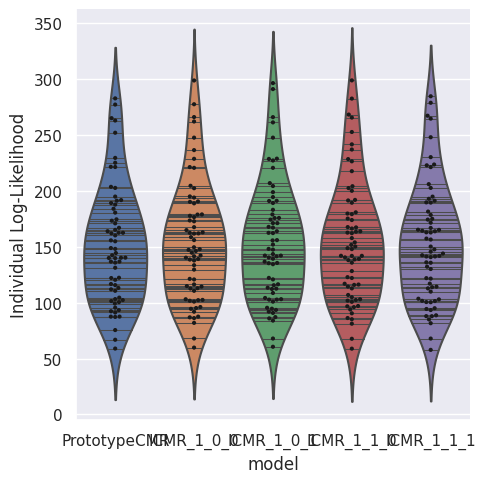

In [5]:
#| code-summary: code -- 3) plot distribution of log-likelihoods across individual subjects

plt.style.use('default')
sns.set(style="darkgrid")

# build individual fits df concatenating results from each model
individual_fits = []
for model_index, model_class in enumerate(models):
    individual_fits.append(
        pd.read_csv(results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index])))
individual_fits = pd.concat(individual_fits, ignore_index=True)

# plot distribution of log-likelihoods across individual subjects
g = sns.catplot(x='model', y='likelihood', data=individual_fits, kind='violin', inner='stick')
sns.swarmplot(x="model", y="likelihood", data=individual_fits, color="k", size=3, ax=g.ax)
g.ax.set_ylabel('Individual Log-Likelihood')
#plt.savefig(results_path + 'individual_{}.pdf'.format(section_tag), bbox_inches="tight")

In [6]:
individual_fits

,subject,trial_count,likelihood,model,encoding_drift_rate,start_drift_rate,recall_drift_rate,shared_support,item_support,learning_rate,primacy_scale,primacy_decay,stop_probability_scale,stop_probability_growth,choice_sensitivity,delay_drift_rate,feature_sensitivity,context_sensitivity,learn_first
0,118,4,111.873736,PrototypeCMR,0.998854,7.597910e-01,0.860963,0.000004,0.054645,0.003260,13.727990,49.391538,1.612949e-02,0.282001,0.227926,0.881658,NaN,NaN,NaN
1,119,5,148.814124,PrototypeCMR,0.645285,1.657160e-02,0.907135,0.837115,0.247612,0.739607,6.111395,47.592004,1.161993e-03,0.614327,4.044495,0.998659,NaN,NaN,NaN
2,123,4,144.332364,PrototypeCMR,0.480187,5.001254e-01,0.738990,0.498740,0.326532,0.005625,8.135311,62.887461,1.436072e-03,0.462884,1.771576,0.790068,NaN,NaN,NaN
3,124,4,191.699636,PrototypeCMR,0.736396,1.786332e-01,0.995810,0.974646,0.154306,0.030837,17.688059,99.184509,2.309219e-04,0.437452,3.040680,0.718639,NaN,NaN,NaN
4,125,5,262.890878,PrototypeCMR,0.802790,7.510671e-01,0.746581,0.181479,0.454903,0.209070,2.225961,0.330330,1.821796e-05,0.344923,3.821438,0.965518,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,311,4,178.448094,ICMR_1_1_1,0.715273,3.300008e-01,0.875235,0.034456,0.885053,0.634728,40.997174,51.590698,5.503282e-05,0.576916,1.000000,0.863252,1.0,6.509090,True
326,312,4,165.056599,ICMR_1_1_1,0.893586,1.317214e-01,0.937621,0.015619,0.967901,0.514335,29.227627,38.446367,7.382082e-05,0.594616,1.000000,0.244049,1.0,2.307481,True
327,313,5,264.570927,ICMR_1_1_1,0.768042,1.867621e-01,0.918148,0.014902,0.721133,0.364003,61.722642,2.433303,2.059551e-04,0.377442,1.000000,0.789500,1.0,2.713406,True
328,314,4,189.664750,ICMR_1_1_1,0.587187,1.677167e-02,0.894403,0.001944,0.370682,0.369948,16.761139,32.705548,1.578042e-07,0.947379,1.000000,0.474957,1.0,2.384232,True


In [7]:
#| code-summary: display markdown rendering of summary table
#| echo: false
#| input: false
#| output: asis

summary_table = pd.DataFrame(group.describe().rename(columns={'likelihood':name}).squeeze()
            for name, group in individual_fits[['model', 'likelihood']].groupby('model')).T.to_markdown()

print("""::: {{#fig-{section_tag}fits layout-nrow=2 layout-valign="center"}}

![]({results_path}individual_{section_tag}.pdf)

{summary_table}

{individual_fits_caption}
:::""".format(section_tag=section_tag, summary_table=summary_table, individual_fits_caption=figure_caption, results_path=results_path))

::: {#fig-HowardKahana2005Cond1fits layout-nrow=2 layout-valign="center"}

![](results/individual_HowardKahana2005Cond1.pdf)

|       |   ICMR_1_0_0 |   ICMR_1_0_1 |   ICMR_1_1_0 |   ICMR_1_1_1 |   PrototypeCMR |
|:------|-------------:|-------------:|-------------:|-------------:|---------------:|
| count |      66      |      66      |      66      |      66      |        66      |
| mean  |     152.971  |     153.503  |     154.367  |     152.14   |       151.473  |
| std   |      53.0941 |      53.5014 |      54.4801 |      52.8325 |        52.7825 |
| min   |      59.7783 |      60.5258 |      58.8196 |      57.7399 |        58.9172 |
| 25%   |     112.691  |     112.294  |     113.131  |     110.579  |       110.899  |
| 50%   |     146.667  |     145.423  |     148.285  |     144.737  |       143.344  |
| 75%   |     178.858  |     181.989  |     180.494  |     180.696  |       183.089  |
| max   |     298.688  |     296.333  |     298.775  |     284.569  |       282.675  |

Dis

In [8]:
#| code-summary: perform t-tests on individual-level fits
#| output: false
 
from scipy.stats import ttest_rel
import itertools

for combination in itertools.combinations(pd.unique(individual_fits.model), 2):

    print(combination)
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='two-sided'))
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='less'))
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='greater'))
    print()

('PrototypeCMR', 'ICMR_1_0_0')
Ttest_relResult(statistic=-3.733050492900854, pvalue=0.00040029668982490544)
Ttest_relResult(statistic=-3.733050492900854, pvalue=0.00020014834491245272)
Ttest_relResult(statistic=-3.733050492900854, pvalue=0.9997998516550876)

('PrototypeCMR', 'ICMR_1_0_1')
Ttest_relResult(statistic=-4.260720276585761, pvalue=6.71465663096739e-05)
Ttest_relResult(statistic=-4.260720276585761, pvalue=3.357328315483695e-05)
Ttest_relResult(statistic=-4.260720276585761, pvalue=0.9999664267168451)

('PrototypeCMR', 'ICMR_1_1_0')
Ttest_relResult(statistic=-5.351694211894311, pvalue=1.214739730380149e-06)
Ttest_relResult(statistic=-5.351694211894311, pvalue=6.073698651900745e-07)
Ttest_relResult(statistic=-5.351694211894311, pvalue=0.9999993926301348)

('PrototypeCMR', 'ICMR_1_1_1')
Ttest_relResult(statistic=-2.502549339180505, pvalue=0.01485434550630244)
Ttest_relResult(statistic=-2.502549339180505, pvalue=0.00742717275315122)
Ttest_relResult(statistic=-2.502549339180505, pva

In [9]:
for combination in itertools.combinations(pd.unique(individual_fits.model), 2):

    print(combination)
    print(np.mean(individual_fits[individual_fits.model == combination[0]].likelihood.values < individual_fits[individual_fits.model == combination[1]].likelihood.values), 
        np.mean(individual_fits[individual_fits.model == combination[1]].likelihood.values < individual_fits[individual_fits.model == combination[0]].likelihood.values))

    print(np.sum(individual_fits[individual_fits.model == combination[0]].likelihood.values < individual_fits[individual_fits.model == combination[1]].likelihood.values), 
        np.sum(individual_fits[individual_fits.model == combination[1]].likelihood.values < individual_fits[individual_fits.model == combination[0]].likelihood.values))

    print()

('PrototypeCMR', 'ICMR_1_0_0')
0.6363636363636364 0.36363636363636365
42 24

('PrototypeCMR', 'ICMR_1_0_1')
0.6363636363636364 0.36363636363636365
42 24

('PrototypeCMR', 'ICMR_1_1_0')
0.8333333333333334 0.16666666666666666
55 11

('PrototypeCMR', 'ICMR_1_1_1')
0.6515151515151515 0.3484848484848485
43 23

('ICMR_1_0_0', 'ICMR_1_0_1')
0.6212121212121212 0.3787878787878788
41 25

('ICMR_1_0_0', 'ICMR_1_1_0')
0.6666666666666666 0.3333333333333333
44 22

('ICMR_1_0_0', 'ICMR_1_1_1')
0.4696969696969697 0.5303030303030303
31 35

('ICMR_1_0_1', 'ICMR_1_1_0')
0.5151515151515151 0.48484848484848486
34 32

('ICMR_1_0_1', 'ICMR_1_1_1')
0.3484848484848485 0.6515151515151515
23 43

('ICMR_1_1_0', 'ICMR_1_1_1')
0.2727272727272727 0.7272727272727273
18 48



In [10]:
def model_weights(positive_log_likelihoods, number_parameters, N):
    AIC = 2 * positive_log_likelihoods + 2 * number_parameters
    AICc = AIC #+ (2*np.power(number_parameters, 2) + 2 * number_parameters) / (N - number_parameters - 2)
    AICd = AIC - np.min(AICc)
    #return AICd
    AICw = np.exp(-.5 * AICd) / np.sum(np.exp(-.5 * AICd))
    return AICw

aicw = {'Model': [], 'Subject': [], 'AICw': []}

total_nlns = np.zeros(len(models))
for subject_index, subject in enumerate(pd.unique(events.subject)):

    subject_specific_trial_mask = np.logical_and(
                    generate_trial_mask(events, f'subject == {subject}'), trial_mask)

    nlnLs = []
    for model_index, model_class in enumerate(models):
        nlnLs.append(
            individual_fits[individual_fits.model == model_names[model_index]].likelihood.values[subject_index])
    nlnLs = np.array(nlnLs)
    total_nlns += nlnLs
    
    weights = model_weights(nlnLs, len(free_parameters[model_index]), np.sum(subject_specific_trial_mask))
    #print(weights)
    for model_index, model_class in enumerate(models):
        aicw['Model'].append(model_names[model_index])
        aicw['Subject'].append(subject)
        aicw['AICw'].append(weights[model_index])

aicw = pd.DataFrame(data=aicw)
total_aicw = model_weights(total_nlns, len(free_parameters[model_index]), np.sum(trial_mask))
print(total_aicw)

[1.00000000e+00 1.15632220e-43 6.44806908e-59 1.10771991e-83
 7.54735326e-20]


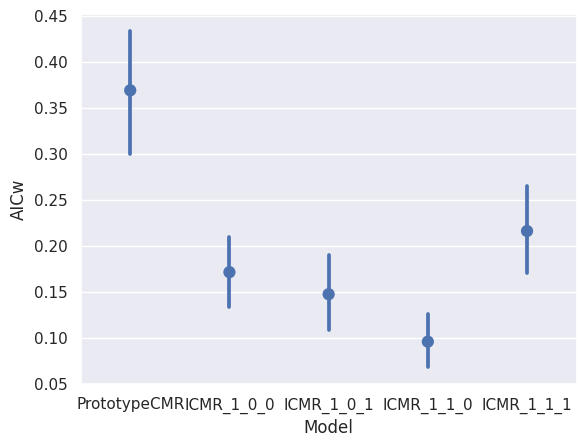

In [11]:
import seaborn as sns
sns.set_theme(style="darkgrid")
x = sns.pointplot(x="Model", y="AICw", data=aicw, join=False)

plt.show()

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [12]:
sns.set(style='darkgrid')

# for each unique list length
if not (isinstance(list_lengths, list) or isinstance(list_lengths, List)): 
    list_lengths = [list_lengths]

for list_length in list_lengths:

    #fig, axes = plt.subplots(nrows=len(models), ncols=3, figsize=(15, int(4*len(models))), sharey=False)
    
    # for each unique model
    for model_index, model_class in enumerate(models):

        # load sim_df from csv if it exists
        sim_df_path = results_path + '{}_{}_ll{}_sim_df.csv'.format(section_tag, model_names[model_index], list_length)
        if os.path.isfile(sim_df_path):
            sim_df = pd.read_csv(sim_df_path)
            print('sim_df for {} with tag {} and list length {} already exists'.format(model_names[model_index], section_tag, list_length))

        # otherwise, generate it
        else:

            # for each unique matching entry in individual df
            sim_dfs = []
            for subject in pd.unique(individual_fits.subject):
                
                fit_result = individual_fits.query(f'subject == {subject} & model == "{model_names[model_index]}"')

                # configure model based on specified parameters
                fitted_parameters = Dict.empty(
                    key_type=types.unicode_type, value_type=types.float64
                )
                for i in range(len(free_parameters[model_index])):
                    fitted_parameters[free_parameters[model_index][i]] = fit_result[free_parameters[model_index][i]].values[0]
                for key in fixed_parameters[model_index]:
                    fitted_parameters[key] = fixed_parameters[model_index][key]

                # simulate df based on specified trial_count and experiment_count
                #model = model_class(list_length, list_length, fitted_parameters)
                sim_dfs.append(simulate_df_from_events(model, fit_result['trial_count'].values[0] * experiment_count))
                sim_dfs[-1].list = sim_dfs[-1].subject
                sim_dfs[-1].subject = subject

            # concatenate simulations into one dataframe
            sim_df = pd.concat(sim_dfs)

            # save sim_df to csv
            sim_df.to_csv(results_path +'{}_{}_ll{}_sim_df.csv'.format(section_tag, model_names[model_index], list_length), index=False)

        # design general filter for analysis df
        if len(list_lengths) > 1:
            analysis_query = trial_query + f' & list_length == {list_length}'
        else:
            analysis_query = trial_query

        # generate plot for each parametrized analysis and model
        for analysis_index, analysis_function in enumerate(analyses):
            analysis_name = analysis_names[analysis_index]
            axis = analysis_function(
                [events, sim_df], analysis_query, contrast_name="source", labels=["data", model_names[model_index]])
            plt.savefig(results_path+'{}_{}_ll{}_{}.pdf'.format(section_tag, model_names[model_index], list_length, analysis_name), bbox_inches="tight")

NameError: name 'simulate_df_from_events' is not defined